In [426]:
import numpy as np
import interpolation
import lobatto
import matplotlib.pyplot as plt
import matrix_generator
import system
import element
import sympy as sym

In [427]:
def linear(args, k=1.0):
    return k*(1+args['y'])

def dlinear(args, k=1.0):
    return k*np.ones_like(args['x'])

In [453]:
boundary = {'N':{'type':'dirichlet' ,'val':linear, 'args':["x","y"]},
              'E':{'type':'dirichlet' ,'val':linear,  'args':["x","y"]},
              'W':{'type':'dirichlet' ,'val':linear, 'args':["x","y"]}, 
              'S':{'type':'dirichlet' ,'val':linear, 'args':["x","y"]}}
n = 10
nx = 3
ny = 3
s = system.system(-1.0,1.0,-1.0,1.0,nx,ny,n,n, num_samples_x=100, exact=False)
s.elements

[[<element.element at 0x7fa3b15b5ed0>,

In [454]:
s.add_property('T',linear,arg_params=['x','y'], sample=True)
s.set_boundaries('T', boundary)
s.ddy(var='T', outVar='dT',fluxType='centered')

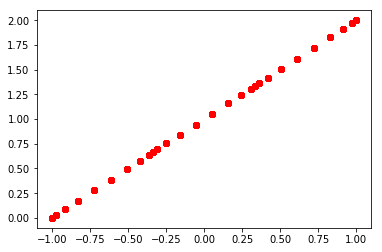

In [455]:
plt.plot(s.properties['y'],s.properties['T'],'ro'); plt.show()

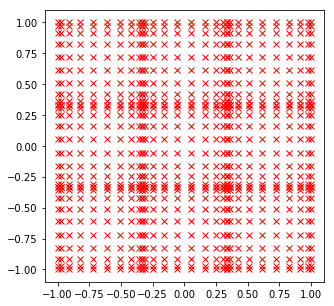

In [456]:
plt.figure(figsize=[5,5]);plt.plot(s.properties['x'],s.properties['y'],'rx'); plt.show()

In [457]:
global_M_inv = np.zeros([nx*n*ny*n,nx*n*ny*n])

global_Dx = np.zeros([nx*n*ny*n,nx*n*ny*n])
global_Dy = np.zeros([nx*n*ny*n,nx*n*ny*n])

global_Fx = np.zeros([nx*n*ny*n,nx*n*ny*n])
global_Fy = np.zeros([nx*n*ny*n,nx*n*ny*n])

a = np.zeros_like(s.Dx)
a[::n,::n] = s.Fx.copy()
a[n-1::n,n-1::n] = -1*s.Fx.copy()

s.Fx_full = a

a = np.zeros_like(s.Dy)
a[:n,:n] = s.Fy.copy()
a[-n:,-n:] = -1*s.Fy.copy()

s.Fy_full = a

In [458]:
for ix in xrange(nx):
    for iy in xrange(ny):
        for row_dest in xrange(n):
            for row_source in xrange(n):
                temp_dest = n*nx*n*iy+n*nx*row_dest+n*ix
                temp_source = n*nx*n*iy+n*nx*row_source+n*ix
                
                l_source = n*row_source
                l_dest   = n*row_dest
                
                global_M_inv[temp_dest:temp_dest+n,temp_source:temp_source+n] = s.M_inv[l_dest:l_dest+n,l_source:l_source+n]
                
                global_Dx[temp_dest:temp_dest+n,temp_source:temp_source+n] = s.Dx[l_dest:l_dest+n,l_source:l_source+n]
                global_Dy[temp_dest:temp_dest+n,temp_source:temp_source+n] = s.Dy[l_dest:l_dest+n,l_source:l_source+n]
                
                global_Fx[temp_dest:temp_dest+n,temp_source:temp_source+n] = s.Fx_full[l_dest:l_dest+n,l_source:l_source+n]
                global_Fy[temp_dest:temp_dest+n,temp_source:temp_source+n] = s.Fy_full[l_dest:l_dest+n,l_source:l_source+n]

In [475]:
global_bx = np.eye(nx*n*ny*n)
global_by = np.eye(nx*n*ny*n)

for ix in xrange(nx-1):
    for iy in xrange(ny):
        for row in xrange(n):
            index_west = n*nx*n*iy+n*nx*row+n*ix
            index_east = index_west + n -1
            global_bx[index_east,index_east] = 0.5
            global_bx[index_east+1,index_east] = 0.5
            global_bx[index_east,index_east+1] = 0.5
            global_bx[index_east+1,index_east+1] = 0.5

for ix in xrange(nx):
    for iy in xrange(ny-1):
        for col in xrange(n):
            index_south = n*nx*n*iy+n*ix+col
            index_north = index_south + n*nx*(n-1)
            global_by[index_north,index_north] = 0.5
            global_by[index_north+n*nx,index_north] = 0.5
            global_by[index_north,index_north+n*nx] = 0.5
            global_by[index_north+n*nx,index_north+n*nx] = 0.5
            
global_Fx = global_Fx.dot(global_bx)
global_Fy = global_Fy.dot(global_by)

In [476]:
derx = -1*global_M_inv.dot(global_Fx + global_Dx)
dery = -1*global_M_inv.dot(global_Fy + global_Dy)

In [479]:
der2x = derx.dot(derx)
der2y = dery.dot(dery)
lap = der2x + der2y

In [462]:
np.max(abs(der2y))

6163.7243684298601

In [481]:
#LHS boundaries

lap[:n*nx] = 0
lap[:n*nx,:n*nx] = np.eye(n*nx)
lap[-n*nx:] = 0
lap[-n*nx:,-n*nx:] = np.eye(n*nx)

lap[::n*nx] = 0
lap[::n*nx,::n*nx] = np.eye(n*ny)
lap[n*nx-1::n*nx] = 0
lap[n*nx-1::n*nx,n*nx-1::n*nx] = np.eye(n*ny)

lap[:n*nx,:n*nx] = dery[:n*nx,:n*nx]
#lap[-n*nx:,-n*nx:] = dery[-n*nx:,-n*nx:]
#lap[n-1::n,n-1::n] = derx[n-1::n,n-1::n]

In [482]:
lap_inv = np.linalg.pinv(lap)

In [483]:
np.linalg.det(lap_inv)

0.0

In [484]:
s.add_property('dT',sample=True)

In [485]:
y = s.properties['dT'].ravel()

In [545]:
y[:] = 0
y[:n*nx]=-5.0  #S
y[-n*nx:]=0.0 #N
y[::n*nx]=0.0 #E
y[n*nx-1::n*nx]=0.0 #W

In [546]:
ing = lap_inv.dot(y).reshape([n*ny,n*nx])

In [547]:
s.properties['T'][:] = ing
s.computeSample('T')

array([[  0.00000000e+00,   2.90210069e-02,   4.99969118e-02, ...,
          4.99969118e-02,   2.90210069e-02,  -8.35622675e-15],
       [  3.38004556e-13,   9.65385019e-03,   1.78657631e-02, ...,
          1.78657631e-02,   9.65385019e-03,   6.52507408e-13],
       [  8.21220271e-13,   4.45274070e-03,   8.77195362e-03, ...,
          8.77195362e-03,   4.45274070e-03,   5.96550933e-13],
       ..., 
       [ -5.34444152e-16,   9.25426422e-06,   1.86184405e-05, ...,
          1.86184405e-05,   9.25426422e-06,   1.07701703e-15],
       [ -6.98018694e-16,   4.74561230e-06,   9.50215633e-06, ...,
          9.50215633e-06,   4.74561230e-06,   1.35991774e-16],
       [  1.99297811e-18,  -3.73394659e-17,  -1.04356025e-16, ...,
         -3.56670071e-16,  -2.30696137e-16,   0.00000000e+00]])

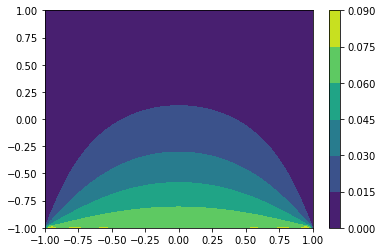

In [548]:
plt.contourf(s.properties['x_sample'],s.properties['y_sample'],s.properties['T_sample']);plt.colorbar();plt.show()

In [549]:
s.add_property('temp')

In [507]:
s.properties['temp'][:] = global_Dx.dot(s.properties['T'].ravel()).reshape(s.properties['temp'].shape)

In [508]:
(s.elements[0][0].properties['temp'])

array([[  1.09739369e-04,  -1.48456126e-04,   5.93955639e-05,
         -3.38669763e-05,   2.24324573e-05,  -1.60689799e-05,
          1.19634650e-05,  -8.92334184e-06,   6.22322127e-06,
         -2.43865265e-06],
       [ -7.09039568e-02,   4.68044229e-02,   1.17415510e-02,
          6.23539223e-03,   9.19656870e-04,   1.84406814e-03,
         -8.22384289e-05,   7.05114825e-04,  -1.28979572e-04,
          2.86496887e-03],
       [ -1.41748106e-01,   4.38039496e-02,   4.16379272e-02,
          2.03638063e-02,   1.07211172e-02,   4.95645144e-03,
          3.05564562e-03,   1.29411507e-03,   7.64857257e-04,
          1.51502361e-02],
       [ -1.89460324e-01,   3.05594236e-02,   4.18596706e-02,
          3.38561852e-02,   2.07373958e-02,   1.19129604e-02,
          6.58309776e-03,   3.54032518e-03,   1.60550713e-03,
          3.88057586e-02],
       [ -2.14809915e-01,   2.12868953e-02,   3.29119131e-02,
          3.33170353e-02,   2.54007807e-02,   1.65023536e-02,
          9.86465760e-03

In [131]:
a = np.zeros([10000,10000])

In [82]:
s.Dx

array([[ -2.63157895e-03,  -3.56020502e-03,   1.42519500e-03, ...,
         -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00],
       [  3.56020499e-03,   3.79142291e-11,  -5.04296792e-03, ...,
          0.00000000e+00,  -0.00000000e+00,   0.00000000e+00],
       [ -1.42519499e-03,   5.04296795e-03,  -5.26014903e-11, ...,
         -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00],
       ..., 
       [  0.00000000e+00,  -0.00000000e+00,   0.00000000e+00, ...,
         -1.82511007e-13,  -5.04296795e-03,   1.42519500e-03],
       [ -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00, ...,
          5.04296795e-03,   3.09048189e-14,  -3.56020499e-03],
       [  0.00000000e+00,  -0.00000000e+00,   0.00000000e+00, ...,
         -1.42519500e-03,   3.56020499e-03,   2.63157895e-03]])

In [83]:
x = s.properties['T'].ravel()
y = s.properties['dT'].ravel()

In [84]:
a = np.zeros_like(s.Dx)
a[::n,::n] = s.Fx.copy()
a[n-1::n,n-1::n] = -1*s.Fx.copy()
derx = -1*s.M_inv.dot(a + s.Dx)
der2x = derx.dot(derx)

a = np.zeros_like(s.Dy)
a[:n,:n] = s.Fy.copy()
a[-n:,-n:] = -1*s.Fy.copy()
dery = -1*s.M_inv.dot(a + s.Dy)
der2y = dery.dot(dery)

lap = der2x+der2y

In [85]:
lap[:n] = 0
lap[:n,:n] = np.eye(n)
lap[-n:] = 0
lap[-n:,-n:] = np.eye(n)

lap[::n] = 0
lap[::n,::n] = np.eye(n)
lap[n-1::n] = 0
lap[n-1::n,n-1::n] = np.eye(n)

#lap[:n,:n] = dery[:n,:n]
#lap[-n:,-n:] = dery[-n:,-n:]
#lap[n-1::n,n-1::n] = derx[n-1::n,n-1::n]

In [86]:
b = np.linalg.inv(lap)

In [87]:
y[:] = 0
y[:n]=0.0
y[-n:]=0.0
y[::n]=1.0
y[n-1::n]=0.0

In [90]:
ing = b.dot(y).reshape([n,n])

In [91]:
s.add_property('T',sample=True)
s.properties['T'][:] = ing

In [92]:
s.computeSample('T')

array([[  1.00000000e+00,  -1.88879695e-02,  -1.21409364e-01, ...,
         -2.50328584e-03,  -1.92734372e-04,   0.00000000e+00],
       [  1.00000000e+00,   8.72822604e-01,   7.62959697e-01, ...,
          1.11042118e-03,   5.76166357e-04,  -5.62794076e-15],
       [  1.00000000e+00,   9.40117211e-01,   8.77831887e-01, ...,
          2.30295358e-03,   1.14287151e-03,   2.30431674e-15],
       ..., 
       [  1.00000000e+00,   9.40117209e-01,   8.77831885e-01, ...,
          2.30295358e-03,   1.14287151e-03,   3.53968023e-16],
       [  1.00000000e+00,   8.72822605e-01,   7.62959699e-01, ...,
          1.11042119e-03,   5.76166359e-04,  -7.57667046e-16],
       [  1.00000000e+00,  -1.88879695e-02,  -1.21409364e-01, ...,
         -2.50328584e-03,  -1.92734372e-04,   0.00000000e+00]])

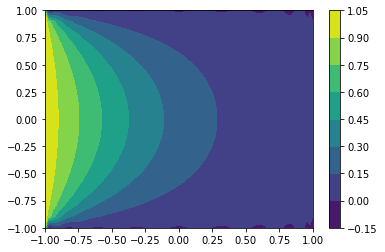

In [93]:
plt.contourf(s.properties['x_sample'],s.properties['y_sample'],s.properties['T_sample']);plt.colorbar();plt.show()

In [94]:
np.max(abs(b))

1.0000000000000226